# Nakładanie na siebie struktur, oraz liczenie RMSD

W tym cwiczeniu przygotujemy skrpyt który będzie odpowienikiem użycia komend pymol:<br>
load data/7qvb_A.pdb<br>
load data/af2_pred.pdb<br>
pair_fit n. CA and resid 5-158 and m. 7qvb_A and c. A,n. CA and resid 9-162 and m. af2_pred and c. A 

In [55]:
import numpy as np

<h3> Etap:1/5 Tworzenie parsera </h3><br>
<a href="https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html">https://www.cgl.ucsf.edu/chimera/docs/UsersGuide/tutorials/pdbintro.html</a>


In [56]:
import numpy as np

def parse_pdb_file(file_path):
    atom_data = []
    
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith(('ATOM', 'HETATH')):
                x = float(line[30:38].strip())
                y = float(line[38:46].strip())
                z = float(line[46:54].strip())
                atom_name = line[12:16].strip()
                residue_seq_number = int(line[22:26].strip())
                chain_id = line[21].strip()
    
        atom_info = {
        'X': x,
        'Y': y,
        'Z': z,
        'AtomName': atom_name,
        'ResidueSeqNumber': residue_seq_number,
        'ChainID': chain_id
        }
        
        atom_data.append(atom_info)
    
    return atom_data

In [57]:
#wykorzystanie funkcji
reference_pdb_path = './data/7qvb_A.pdb'
model_pdb_path = './data/af2_pred.pdb'

reference_data = parse_pdb_file(reference_pdb_path)
model_data = parse_pdb_file(model_pdb_path)

<h3>Etap:2/5 tworzenie filtru danych</h3>

In [58]:
def filter_atom_dataA(atom_data, residue_numbers, atom_name):
    filtered_atom_data = [elem for elem in atom_data if elem["AtomName"] == atom_name and elem["ResidueSeqNumber"] in residue_numbers]
    

    return filtered_atom_data  

In [59]:
def filter_atom_data(atom_data, residue_numbers, atom_name):
    filtered_atom_data = []

    for atom_info in atom_data:
        if (atom_info['ResidueSeqNumber'] in residue_numbers) and (atom_info['AtomName'] == atom_name):
            filtered_atom_data.append(atom_info)

    return filtered_atom_data

In [60]:
#wykorzystanie funkcji
atom_name_to_filter = 'CA'

residue_numbers_to_filter = list(range(5,159))
filtered_reference_data = filter_atom_data(reference_data, residue_numbers_to_filter, atom_name_to_filter)

residue_numbers_to_filter = list(range(9,163))
filtered_model_data = filter_atom_data(model_data, residue_numbers_to_filter, atom_name_to_filter)

print(len(filtered_reference_data))
print(len(filtered_model_data))

0
0


<h3> Etap: 3/5 ekstrakcja położeń atomów</h3>

In [61]:
def extract_xyz_positions(atom_data):
    xyz_positions = np.array([[atom["X"], atom['Y'], atom["Z"]] for atom in atom_data])
    return xyz_positions

In [62]:
def extract_xyz_positions(atom_data):
    xyz_positions = np.array([[atom_info['X'], atom_info['Y'], atom_info['Z']] for atom_info in atom_data])
    return xyz_positions

In [75]:
#uzyj kodu
filtered_reference_data_xyz = extract_xyz_positions(filtered_reference_data)
filtered_model_data_xyz = extract_xyz_positions(filtered_model_data)
print(filtered_reference_data_xyz)
filtered_reference_data_xyz_own = extract_xyz_positions(filtered_reference_data)
filtered_model_data_xyz_own = extract_xyz_positions(filtered_model_data)

[]


<h3> Etap 4/5 Nałożenie na siebie struktur</h3><br>
Google: Finding optimal rotation and translation between corresponding 3d points python<br>
<a href="https://nghiaho.com/?page_id=671">https://nghiaho.com/?page_id=671</a><br>
<a href="https://jasonblog.github.io/note/math/finding_optimal_rotation_and_translation_between_c.html">https://jasonblog.github.io/note/math/finding_optimal_rotation_and_translation_between_c.html</a>




In [64]:
def align_coordinates(xyz_A, xyz_positions_B):
    assert len(xyz_A) == len(xyz_positions_B)

    N = xyz_A.shape[0]  # total points

    centroid_A = np.mean(xyz_A, axis=0)
    centroid_B = np.mean(xyz_positions_B, axis=0)

    # center the points
    AA = xyz_A - np.tile(centroid_A, (N, 1))
    BB =  xyz_positions_B - np.tile(centroid_B, (N, 1))

    # dot is matrix multiplication for array
    H = np.transpose(AA) @ BB

    U, S, Vt = np.linalg.svd(H)

    R = Vt.T @ U.T

    # special reflection case
    if np.linalg.det(R) < 0:
        print("Reflection detected")
        Vt[2, :] *= -1
        R = Vt.T @ U.T

    t = -R @ centroid_A.T + centroid_B.T

    print(t)

    return R, t

In [ ]:
#użeyj kodu
R,t=align_coordinates( filtered_model_data_xyz,filtered_reference_data_xyz)
filtered_model_data_xyz_fitted=filtered_model_data_xyz@R.T+t
print(filtered_model_data_xyz_fitted)

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

<h3> 5/5 Obliczanie RMSD</h3>

In [67]:
def calculate_rmsd(xyz_positions_reference, xyz_positions_model):
    
    diff = np.sum(np.square(xyz_positions_reference - xyz_positions_model), axis=1)
    mean = np.mean(diff)
    rmsd = np.sqrt(mean)
    
    return rmsd

In [ ]:
print(f"RMSD pre fit: {calculate_rmsd(filtered_reference_data_xyz, filtered_model_data_xyz)}") 
print(f"RMSD post fit: {calculate_rmsd(filtered_reference_data_xyz, filtered_model_data_xyz_fitted)}") 

AxisError: axis 1 is out of bounds for array of dimension 1

# Obliczanie GDT_TS przy pomocy biblioteki pymol

In [77]:
!pip install -q condacolab

2868.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [76]:
import condacolab
condacolab.install()

ModuleNotFoundError: No module named 'condacolab'

In [72]:
!sed -i '/cudatoolkit/d' /usr/local/conda-meta/pinned

2284.96s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
sed: 1: "/usr/local/conda-meta/p ...": extra characters at the end of l command


In [73]:
!conda install conda-forge::pymol-open-source
#https://pymolwiki.org/index.php/Main_Page

2293.74s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Retrieving notices: ...working... done
Channels:
 - salilab
 - conda-forge
 - bioconda
 - defaults
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /Users/mikolajturczyniak/anaconda3

  added / updated specs:
    - conda-forge::pymol-open-source


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    blosc-1.21.5               |       hc338f07_0          33 KB  conda-forge
    cached-property-1.5.2      |       hd8ed1ab_1           4 KB  conda-forge
    cached_property-1.5.2      |     pyha770c72_1          11 KB  conda-forge
    curl-8.5.0                 |       h02f6b3c_0          79 KB
    fmt-10.1.1                 |       h2ffa867_1         168 KB  conda-forge
    gettext-0.21.1             |       h0186832_0         3.8 MB  conda-forge
    glew-2.1.0  

In [79]:
import pymol

ModuleNotFoundError: No module named 'pymol'

In [ ]:
#zaczynanie od poczatku
pymol.cmd.delete('all')

#otwieranie struktur
pymol.cmd.load('7qvb_A.pdb', object="reference")
# pymol.cmd.load('af2_pred.pdb', object="model_")
pymol.cmd.load('I-TASSER_exclude.pdb', object="model_")
# pymol.cmd.load('I-TASSER_100ident.pdb', object="model_")

#dopasowanie af2_pred do 7qvb_A
rmsd=pymol.cmd.pair_fit("n. CA and resid 9-162+173-226 and m. model_ and c. A",
                  "n. CA and resid 5-158+169-222 and m. reference and c. A and not alt B")




#stwórz pętle po resids z model_resids oraz reference_resids, a następnie oblicz dystans za pomoca get_distance
#pomiedzy atomami CA
model_resids=list(range(9,163))+list(range(173,227))
reference_resids=list(range(5,159))+list(range(169,223))
n_1=0
n_2=0
n_4=0
n_8=0
n_total=len(reference_resids)
#petla
for resid_model, resid_ref in zip(model_resids, reference_resids):
    atom1=f"n. CA and resid {resid_model} and m. model_ and c. A"
    atom2=f"n. CA and resid {resid_ref} and m. reference and c. A and not alt B"
    distance=pymol.cmd.get_distance(atom1=atom1, atom2=atom2)

    if distance <= 1: n_1 += 1

    if distance <= 2: n_2 += 1

    if distance <= 4: n_4 += 1

    if distance <= 8: n_8 += 1

    #sprawdz czy odpowiadajace sobie atomy (atom1 oraz atom2) spełniaja pierwsza kategorie -> dystans mniejszy od 1
    # jesli tak podnies o 1 licznik n_1
    #itd

#Oblicz GDT_P1, GDT_P2,GDT_P4,GDT_P8
GDT_P1 = n_1 / n_total * 100
GDT_P2 = n_2 / n_total * 100
GDT_P4 = n_4 / n_total * 100
GDT_P8 = n_8 / n_total * 100
# GDT_TS - GlobalDistanceTest_TotalScore
GDT_TS = (GDT_P1 + GDT_P2 + GDT_P4 + GDT_P8)/4
#Oblicz GDT_TS

 ExecutiveRMSPairs: RMSD =    1.802 (208 to 208 atoms)
33.17307692307692 86.53846153846155 99.03846153846155 99.03846153846155
GDT_TS wynosi: 79.45%


In [74]:
print(GDT_P1,GDT_P2,GDT_P4,GDT_P8)
print("GDT_TS wynosi: %.2f%%" % GDT_TS)

NameError: name 'GDT_P1' is not defined

<h2>TM-SCORE</h2>

Proszę wejść na stronę:<br>
<a href="https://zhanggroup.org/TM-score/">https://zhanggroup.org/TM-score/</a>

Jako model spróbować użyć:
1. data/af2_pred_truncated_aligned.pdb
2. data/I-TASSER_exclude_truncated_aligned.pdb
3. I-TASSER_100ident_truncated_aligned.pdb

Jako strukturę eksperymentalną:
data/7qvb_A.pdb

<h2>Verify 3D</h2>

Wejdź na stronę Verify3D:<br>
<a href="https://www.doe-mbi.ucla.edu/verify3d/">https://www.doe-mbi.ucla.edu/verify3d/</a>    <br><br>
A następnie:<br>
-uruchom program dla naszej referncji-struktury eksperymentalnej<br>
data/7qvb_A.pdb<br>
-uruchom program dla modelu z alphafold2<br>
data/af2_pred.pdb<br>
-uruchom program dla modelu z serwera I-TASSER<br>
data/I-TASSER_exclude.pdb<br>

Dla wyników z af2 nacisnij na przycisk "Save to data file" a nastepnie dla tego zestawu danych wygeneruj podobny<br>
wykres do tego z strony verify3D

In [2]:
from matplotlib import pyplot as plt
import numpy as np

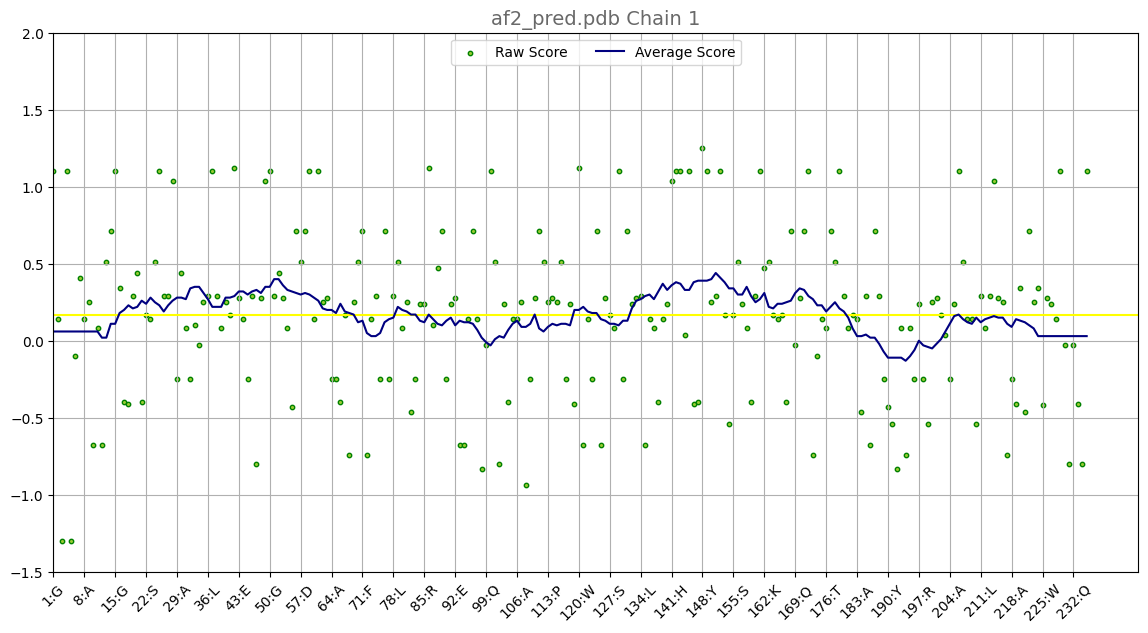

In [9]:
from matplotlib import pyplot as plt

with open("./af2.txt", "r", encoding="utf-8") as f:
    data = f.readlines()[1:]
    result = []
    for rows in data:
        rows = rows.replace("\n", "")
        columns = rows.split("\t")
        joined_row = ":".join(columns[:2])
        rest_of_elements = columns[2:]
        result.append((joined_row, rest_of_elements))

positions = [item[0] for item in result[1:]]
raw_scores = [float(item[1][0]) for item in result[1:]]
average_scores = [float(item[1][1]) for item in result[1:]]

average_average = sum(average_scores) / len(average_scores)
plt.figure(figsize=(14, 7))
plt.axhline(y=average_average, color="yellow", linestyle="-")
raw_score_plot = plt.scatter(
    positions,
    raw_scores,
    color="yellowgreen",
    marker="o",
    edgecolors="green",
    s=10,
    label="Raw Score",
)
average_score_plot = plt.plot(
    positions, average_scores, color="navy", linestyle="-", label="Average Score"
)
plt.title("af2_pred.pdb Chain 1", color="dimgray", fontsize=14)
plt.xticks(positions[::7], positions[::7], rotation=45)
plt.grid()
plt.ylim(-1.5, 2)
plt.xlim(left=0)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1), ncol=3)
plt.show()
